#Preparation: importing libraries and loading data#

Please run this notebook in Google Colab and change runtime type for GPU. This is required for fast learning.

In [1]:
#installing the version of xgboost that supports GPU
!pip uninstall xgboost
!pip install xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl

Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Processing ./xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl


In [2]:
#importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import warnings
import xgboost as xgb
import gc
%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
print(xgb.__version__)

0.80


In [0]:
def downcast_dtypes(df):

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
#loading data
sales = pd.read_csv('sales_train_v2.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

print(sales.shape)

(2935849, 6)


The 'sales' file contains only the cases when the target is not zero, in general that's not true, so we'll have to aggregate more combinations of item_id, shop_id and date_block_num for which target can be 0.

In [5]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in sales['date_block_num'].unique():
  cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
  cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
  grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'item_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

train = downcast_dtypes(train)

del gb, grid
gc.collect();

print(train.shape)
train.head(2)

(10913850, 4)


,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0


In [0]:
#sorting train set with respect to date (just in case)
train = train.sort_values('date_block_num').reset_index(drop = True)

We'll clip target value in (0, 20) interval for more stable model.

In [0]:
train['item_cnt_month'] = train['item_cnt_month'].clip(0, 20)

In [8]:
#concatenating train and test so that it's more convinient to generate features
test_plus = test.drop(['ID'], axis = 1)
test_plus['date_block_num'] = 34
test_plus['item_cnt_month'] = 0.
data = pd.concat([train, test_plus])

del train, test_plus
gc.collect()
data.shape

(11128050, 4)

#The basic feature engineering#

First of all, let's add some lag based features.

In [9]:
#getting the sales for four previous months and for two months a year before
temp = data.set_index(['date_block_num', 'shop_id', 'item_id'])

for i in range(1, 5):
  data = data.join(temp, on = [data['date_block_num'] - i, 'shop_id', 'item_id'], rsuffix = '_lag' + str(i))
  print(i)
  gc.collect()
  
data = data.join(temp, on = [data['date_block_num'] - 12, 'shop_id', 'item_id'], rsuffix = '_lag' + '12')
gc.collect()
print(12)
data = data.join(temp, on = [data['date_block_num'] - 13, 'shop_id', 'item_id'], rsuffix = '_lag' + '13')
gc.collect()
print(13)

1
2
3
4
12
13


In [10]:
#trying to exploit seasonal trends
data['previous_uplift'] = data['item_cnt_month_lag12'] - data['item_cnt_month_lag13']
data['same_uplift'] = data['item_cnt_month_lag1'] + data['previous_uplift']

data = downcast_dtypes(data)
gc.collect()

54

In [11]:
#sales with respect to shops and items for previous four months
item_sales = data.groupby(['item_id', 'date_block_num'])['item_cnt_month'].sum().reset_index()
shop_sales = data.groupby(['shop_id', 'date_block_num'])['item_cnt_month'].sum().reset_index()

for i in range(1, 5):
  data = data.join(item_sales.set_index(['item_id', 'date_block_num']), on = ['item_id', data['date_block_num'] - i], 
                  rsuffix = '_item_sum_' + str(i))
  data = data.join(shop_sales.set_index(['shop_id', 'date_block_num']), on = ['shop_id', data['date_block_num'] - i], 
                  rsuffix = '_shop_sum_' + str(i))
gc.collect()

308

In [12]:
#the time series differentiation

data['diff1'] = data['item_cnt_month_lag1'] - data['item_cnt_month_lag2']
data['diff2'] = data['item_cnt_month_lag2'] - data['item_cnt_month_lag3']
data['diff3'] = data['item_cnt_month_lag3'] - data['item_cnt_month_lag4']

data = downcast_dtypes(data)
gc.collect()

34

In [0]:
#handling price
prices = sales.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean()
data = data.join(prices, on = ['shop_id', 'item_id', data['date_block_num'] - 1])

In [0]:
#adding revenue for previous month
data['revenue'] = data['item_cnt_month_lag1'] * data['item_price']

Time to add price lags

With respect to items:

In [0]:
n_shops = shops.shape[0]
item_prices_mean = sales.groupby(['item_id', 'date_block_num'])['item_price'].mean()

for i in range(1, 4):
  item_prices_mean.rename('item_prices_mean_lag' + str(i), inplace = True)
  data = data.join(item_prices_mean, on = ['item_id', data['date_block_num'] - i])
  gc.collect()

With respect to shops:

In [0]:
n_items = items.shape[0]
shop_prices_mean = sales.groupby(['shop_id', 'date_block_num'])['item_price'].mean()

for i in range(1, 4):
  shop_prices_mean.rename('shop_prices_mean_lag' + str(i), inplace = True)
  data = data.join(shop_prices_mean, on = ['shop_id', data['date_block_num'] - i])
  gc.collect()

Now, revenue is NaN if no items were bought in the shop and the price is NaN in the same case. But we can't fill NaNs in price with zeros, so let's just fill it with the mean price of this item.

In [0]:
data['item_price_mean'] = data.groupby(['item_id'])['item_price'].transform('mean')
data['shop_price_mean'] = data.groupby(['shop_id'])['item_price'].transform('mean')

data['item_price'].fillna(data['item_price_mean'], inplace = True)
for i in range(1,4):
  data['item_prices_mean_lag' + str(i)].fillna(data['item_price_mean'])
  data['shop_prices_mean_lag' + str(i)].fillna(data['shop_price_mean'])  

But there are still some NaNs and now we can do nothing but fill them with global mean.

In [0]:
data['item_price'].fillna(data['item_price'].mean(), inplace = True)

And let's add month as it can be useful.

In [0]:
data['month'] = data['date_block_num'] % 12

#Some EDA#

Let's look at shops.

In [20]:
shops.head(7)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6


It seems that all shop names begin with the name of the city where they are located. 'Адыгея', 'Балашиха', 'Вологда' - all of them are Russian towns.

In [21]:
shops['shop_city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops['shop_city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

This seems almost fine, but:


*   '!Якутск' and 'Якутск' are basically the same city.
*   'Интернет-магазин' means an online shop, so we can add a new feature 'purchased_on_Internet'.



In [0]:
shops['shop_city'].replace({'!Якутск' : 'Якутск'}, inplace = True)
shops['purchased_on_Internet'] = shops['shop_city'].apply(lambda x: int(x == 'Интернет-магазин'))

Let's deal with items.

In [23]:
items.head(7)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40


Interesting, items have a weird letter 'D' in the end of their names. What could it be?

In [24]:
items['item_name'].apply(lambda x: x[-1]).unique()

array(['D', ']', 'ь', ')', '2', 'С', 'О', '/', 'Д', 'П', '»', '1', 'Я',
       'd', '.', 'В', 'А', 'Й', 'и', 'Ы', '"', 'в', 'к', 'а', 'т', 'е',
       'й', 'я', 'о', 'у', 'ы', 'k', 'р', '3', 'х', 'м', 'с', '!', 'B',
       'з', '8', '6', 'e', 'm', ',', '0', 'н', 'P', 'п', '5', '[', 'Э',
       'Е', '4', 'И', 'Н', 's', 'r', 'г', 'д', 'L', 'S', '9', 'n', '?',
       'М', 'l', 'g', 't', 'o', 'h', 'c', 'a', 'f', 'y', 'X', 'O', 'G',
       'p', 'i', 'w', 'M', 'x', 'W', 'Р', 'u', 'z', 'C', 'E', 'К', 'N',
       'T', '7', 'У', 'I', 'A', 'Ц', 'л', 'ф', 'ч', 'Ь', 'K', 'U', ':',
       'H', 'R', 'V', 'Ю', 'Т', 'Ъ', 'Л', 'Ж', 'Y', 'Х', 'Ш', '+', 'Б',
       'ц', 'Z', 'Г', 'э', 'б', '*', 'ю', 'Ф', 'ё', 'Щ', 'Ч', 'ш', 'ж',
       'b', 'З', 'J', 'щ', 'F', 'ъ'], dtype=object)

Some of items have in the just letters in the lowercase or numbers - the stuff you expect to see in the end of the item_name, but some have these english uppercase letters. I have no idea what this means but we have to use it somehow.

In [0]:
items['last_letter'] = items['item_name'].apply(lambda x: x[-1])
items['last_letter_weird'] = items['last_letter'].apply(lambda x: int((ord(x) >= ord('A')) and (ord(x) <= ord('Z'))))

And, finally, let's investigate categories.

In [26]:
item_cat.head(7)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6


If we look at the names, we'll see that many of them consist of two separate parts divided by dash. We can use that.

In [0]:
item_cat['first_part_of_name'] = item_cat['item_category_name'].apply(lambda x: x.split('-')[0])
item_cat['second_part_of_name'] = item_cat['item_category_name'].apply(lambda x: x.split('-')[-1])

Let's also apply TF-IDF to category names and item names.

In [0]:
#extracting features from text via TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

items_corpus = items['item_name']
item_cat_corpus = item_cat['item_category_name']

vectorizer = TfidfVectorizer()
item_tfidf = vectorizer.fit_transform(items_corpus)
item_cat_tfidf = vectorizer.fit_transform(item_cat_corpus)

However, these matrices are too big to use them raw. We'll decompose them with Non-negative matrix factorization.

In [0]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 5)

item_nmf = nmf.fit_transform(item_tfidf)
item_cat_nmf = nmf.fit_transform(item_cat_tfidf)

item_cols = ['item_TF-IDF' + str(i) for i in range(5)] 
item_cat_cols = ['item_cat_TF-IDF' + str(i) for i in range(5)]

items = pd.concat([items, pd.DataFrame(item_nmf, columns = item_cols)], axis = 1, sort = False)
item_cat = pd.concat([item_cat, pd.DataFrame(item_cat_nmf, columns = item_cat_cols)], axis = 1, sort = False)

And, finally, we'll add them to data.

In [30]:
data = data.join(items.set_index('item_id'), on = 'item_id')
data = data.join(shops.set_index('shop_id'), on = 'shop_id')
data = data.join(item_cat.set_index('item_category_id'), on = 'item_category_id')
data.drop(['item_name', 'shop_name', 'item_category_name'], axis = 1, inplace = True) #We don't need this
print(data.shape)
gc.collect()
data.head(2)

(11128050, 51)


,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag4,item_cnt_month_lag12,item_cnt_month_lag13,previous_uplift,same_uplift,item_cnt_month_item_sum_1,item_cnt_month_shop_sum_1,item_cnt_month_item_sum_2,item_cnt_month_shop_sum_2,item_cnt_month_item_sum_3,item_cnt_month_shop_sum_3,item_cnt_month_item_sum_4,item_cnt_month_shop_sum_4,diff1,diff2,diff3,item_price,revenue,item_prices_mean_lag1,item_prices_mean_lag2,item_prices_mean_lag3,shop_prices_mean_lag1,shop_prices_mean_lag2,shop_prices_mean_lag3,item_price_mean,shop_price_mean,month,item_category_id,last_letter,last_letter_weird,item_TF-IDF0,item_TF-IDF1,item_TF-IDF2,item_TF-IDF3,item_TF-IDF4,shop_city,purchased_on_Internet,first_part_of_name,second_part_of_name,item_cat_TF-IDF0,item_cat_TF-IDF1,item_cat_TF-IDF2,item_cat_TF-IDF3,item_cat_TF-IDF4
0,59,22154,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.523810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.52381,829.073732,0,37,),0,0.000056,0.081478,0.000127,0.000865,0.001075,Ярославль,0,Кино,Ray,0.0,0.000000,0.0,0.077714,0.0
1,35,2565,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683.866854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,854.051896,0,56,),0,0.000000,0.000083,0.004742,0.001919,0.000000,Н.Новгород,0,Музыка,CD фирменного производства,0.0,0.007155,0.0,0.032959,0.0


In [31]:
data  = downcast_dtypes(data)
gc.collect()

189

#Mean encodings#

We've already accumulated lots of categorical features, so let's mean encode them using expanding mean scheme.

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
cat_cols = ['shop_id', 'item_id', 'month', 'item_category_id', 'shop_city', 'first_part_of_name', 'last_letter',
           'second_part_of_name']

cols_to_encode = ['first_part_of_name', 'second_part_of_name', 'shop_city', 'last_letter']

le = LabelEncoder()
for col in cols_to_encode:
  data[col] = data[col].apply(str)
  data[col] = le.fit_transform(data[col])
gc.collect()

globalmean = data['item_cnt_month'].mean()

for col in cat_cols:
  sums = data.groupby(col)['item_cnt_month'].cumsum() - data['item_cnt_month']
  counts = data.groupby(col)['item_cnt_month'].cumcount() + 1
  data[col + '_encoded'] = sums / counts
  data[col + '_encoded'].fillna(globalmean, inplace = True)

So, now our data looks like:

In [33]:
data[8000000:8000004]

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag4,item_cnt_month_lag12,item_cnt_month_lag13,previous_uplift,same_uplift,item_cnt_month_item_sum_1,item_cnt_month_shop_sum_1,item_cnt_month_item_sum_2,item_cnt_month_shop_sum_2,item_cnt_month_item_sum_3,item_cnt_month_shop_sum_3,item_cnt_month_item_sum_4,item_cnt_month_shop_sum_4,diff1,diff2,diff3,item_price,revenue,item_prices_mean_lag1,item_prices_mean_lag2,item_prices_mean_lag3,shop_prices_mean_lag1,shop_prices_mean_lag2,shop_prices_mean_lag3,item_price_mean,shop_price_mean,month,item_category_id,last_letter,last_letter_weird,item_TF-IDF0,item_TF-IDF1,item_TF-IDF2,item_TF-IDF3,item_TF-IDF4,shop_city,purchased_on_Internet,first_part_of_name,second_part_of_name,item_cat_TF-IDF0,item_cat_TF-IDF1,item_cat_TF-IDF2,item_cat_TF-IDF3,item_cat_TF-IDF4,shop_id_encoded,item_id_encoded,month_encoded,item_category_id_encoded,shop_city_encoded,first_part_of_name_encoded,last_letter_encoded,second_part_of_name_encoded
8000000,58,4418,22,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,1965.0,11.0,2088.0,18.0,2633.0,13.0,2166.0,-1.0,0.0,1.0,296.936554,NaN,299.000000,299.000000,292.944458,922.806763,864.210754,819.373962,296.936554,759.14502,10,55,63,0,0.000265,0.000014,0.000782,0.000204,0.000000,29,0,13,1,0.000000,0.007155,0.0,0.032959,0.0,0.359564,0.201305,0.316654,0.221770,0.496928,0.172754,0.245543,0.221770
8000001,58,1916,22,3.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,110.0,1965.0,107.0,2088.0,136.0,2633.0,130.0,2166.0,-1.0,0.0,1.0,249.000000,249.0,246.736877,247.869904,244.165543,922.806763,864.210754,819.373962,244.066895,759.14502,10,30,46,0,0.044270,0.000000,0.023485,0.043217,0.000000,29,0,8,50,0.000000,0.329678,0.0,0.000000,0.0,0.359562,3.727866,0.316654,1.147175,0.496927,0.747564,0.691878,1.147175
8000002,58,4408,22,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,1965.0,3.0,2088.0,NaN,2633.0,NaN,2166.0,0.0,NaN,NaN,297.322144,NaN,297.137268,299.000000,NaN,922.806763,864.210754,819.373962,297.322144,759.14502,10,55,64,0,0.000000,0.000000,0.000007,0.000039,0.000000,29,0,13,1,0.000000,0.007155,0.0,0.032959,0.0,0.359579,0.630435,0.316658,0.221770,0.496934,0.172754,0.172269,0.221770
8000003,58,4396,22,1.0,0.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,16.0,1965.0,6.0,2088.0,19.0,2633.0,20.0,2166.0,0.0,-2.0,1.0,2551.679932,NaN,2540.968750,2599.000000,2560.985596,922.806763,864.210754,819.373962,2551.679932,759.14502,10,23,46,0,0.000000,0.000750,0.000942,0.096680,0.000784,29,0,5,15,0.066383,0.321569,0.0,0.000000,0.0,0.359577,0.455959,0.316658,0.683111,0.496933,0.693735,0.691880,0.657877


In [34]:
#dowcasting types in order to save memory
data = downcast_dtypes(data)
gc.collect()

21

We have to erase first 13 months as our lag is 13.

In [0]:
data = data[data.date_block_num >= 13]
data.fillna(0)
gc.collect()
data.to_csv('data.csv', index = False)

#Fitting models#

**Important moment** - you may be running out of RAM at this point. If that is an issue, just restart runtime and download 'data.csv' file.

In [1]:
#Run this cell if you've restarted runtime.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import warnings
import xgboost as xgb
import gc
%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
print(xgb.__version__)

0.80


Out stacking scheme wil be the following:

*   Fitting random forest and gradient boosting on train data (date_block_num <= 32) and validating them on validation data (date_block_num = 33)
*   Predicting meta-features for validation and test data
*   Fitting linear regression on meta-features using validation data (linear regression doesn't have any parameters, so we won't need to validate it)
* Predicting values for the test set.


In [2]:
#dividing data on train, validation and test
#data = pd.read_csv('data.csv') #Uncomment if you've restarted runtime.

train_data = data[(data.date_block_num < 33) & (data.date_block_num >= 13)]
val_data = data[data.date_block_num == 33]
test_data = data[data.date_block_num == 34]

del data
gc.collect()

4

We load data in DMatrix to use non-sklearn interface of XGBoost. For unknown reasons, the sklearn interface raises errors while training on GPU.

In [0]:
columns = train_data.drop(['item_cnt_month'], axis = 1).columns
xgb_train = xgb.DMatrix(train_data.drop(['item_cnt_month'], axis = 1).values,
                         label = train_data['item_cnt_month'].values, feature_names = columns)

In [0]:
xgb_val = xgb.DMatrix(val_data.drop(['item_cnt_month'], axis = 1).values, feature_names = columns, 
                     label = val_data['item_cnt_month'].values)

In [0]:
xgb_test = xgb.DMatrix(test_data.drop(['item_cnt_month'], axis = 1).values, feature_names = columns)
X_test = test_data.drop('item_cnt_month', axis = 1).values

These parameters are roughly optimal as I've learned after performing some experiments.

In [6]:
#fitting gradient boosting
param = {'gpu_id' : 0, 'tree_method' : 'gpu_hist', 'max_bin' : 1024, 
        'eval_metric' : 'rmse', 'max_depth' : 7, 'min_child_weight' : 300, 'subsample' : 0.7, 
         'colsample_bytree' : 0.9, 'seed' : 42}

tree_boosting = xgb.train(param, xgb_train, num_boost_round = 50)
print('Score on validation set for first level models: ', tree_boosting.eval(xgb_val))

Score on validation set for first level models:  [0]	eval-rmse:0.804056


In [7]:
#fitting random forest
param = {'gpu_id' : 0, 'tree_method' : 'gpu_hist', 'max_bin' : 1024, 
        'eval_metric' : 'rmse', 'num_parallel_tree' : 200, 'max_depth' : 10, 'min_child_weight' : 200,
        'seed' : 42}

random_forest = xgb.train(param, xgb_train, num_boost_round = 1)
print('Score on validation set for first level models: ', random_forest.eval(xgb_val))

Score on validation set for first level models:  [0]	eval-rmse:1.003205


In [0]:
#fitting metamodel - linear regression
from sklearn.linear_model import LinearRegression
meta_val = np.vstack((tree_boosting.predict(xgb_val), random_forest.predict(xgb_val))).T
meta_test = np.vstack((tree_boosting.predict(xgb_test), random_forest.predict(xgb_test))).T

metamodel = LinearRegression()
metamodel.fit(meta_val, xgb_val.get_label())
test_predictions = metamodel.predict(meta_test)

In [0]:
#downloading the file with predictions
sample = pd.read_csv('sample_submission.csv')
sample['item_cnt_month'] = test_predictions.clip(0,20)
sample.to_csv('result.csv', index = False) #0.995926 and 0.997697

Let's look at feature importances in the gradient boosting model.

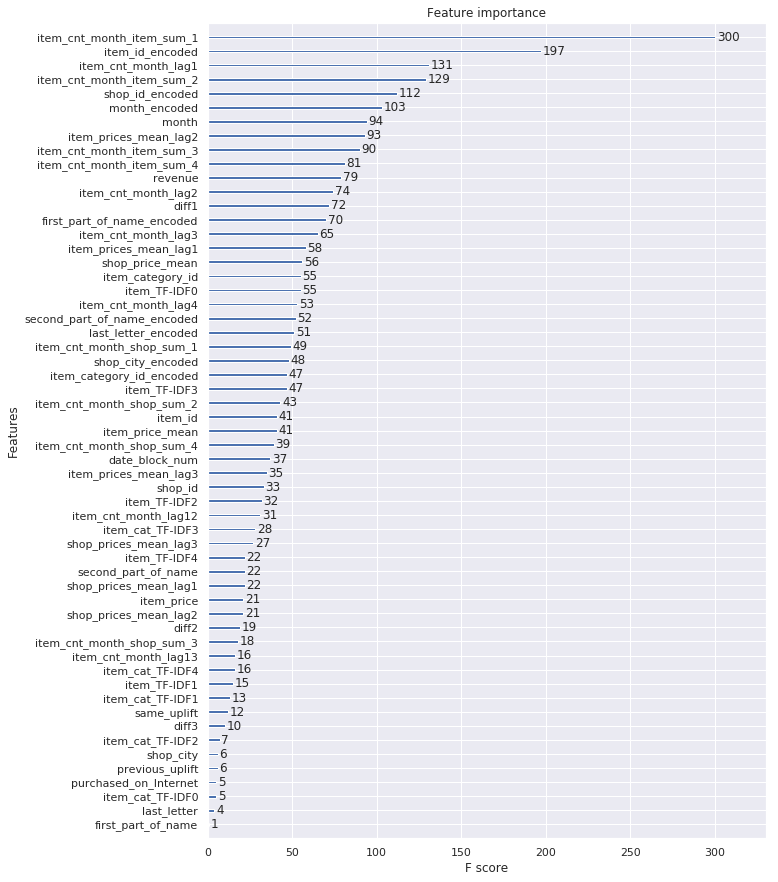

In [11]:
fig, ax = plt.subplots(1,1,figsize = (10, 15))
plot = xgb.plot_importance(tree_boosting, ax=ax)
fig = plot.get_figure()
fig.savefig('importances.png')
plot

#Getting the simplified model (required for Kaggle Winning Model documentation).#

In [0]:
best_cols = ['item_cnt_month_item_sum_1', 'item_id_encoded', 'item_cnt_month_lag1', 'item_cnt_month_item_sum_2',
            'month', 'shop_id_encoded', 'month_encoded', 'item_cnt_month_lag2', 'item_prices_mean_lag2']

xgb_train_simple = xgb.DMatrix(train_data[best_cols].values, label = train_data['item_cnt_month'])
xgb_val_simple = xgb.DMatrix(val_data[best_cols].values, label = val_data['item_cnt_month'].values)
xgb_test_simple = xgb.DMatrix(test_data[best_cols].values)

In [15]:
param = {'gpu_id' : 0, 'tree_method' : 'gpu_hist', 'max_bin' : 1024, 
        'eval_metric' : 'rmse', 'seed' : 42}
simple_boosting = xgb.train(param, xgb_train_simple, num_boost_round = 30)

print('Score on validation set for first level models: ', simple_boosting.eval(xgb_val_simple))

simple_pred = simple_boosting.predict(xgb_test_simple)

Score on validation set for first level models:  [0]	eval-rmse:0.865870


In [0]:
sample = pd.read_csv('sample_submission.csv')
sample['item_cnt_month'] = simple_pred.clip(0,20)
sample.to_csv('result_simple.csv', index = False) #1.012726 and 1.017646